Nama = Anas Fikri Hanif\
SIB ID = M183X0321

#**Import Library**

In [8]:
# Data loading and data analysis
import numpy as np
import pandas as pd
import zipfile
from google.colab import files

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Modeling
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

#**Preparing Dataset From Kaggle**

In [2]:
# Install kaggle 
!pip install -q kaggle

In [5]:
# Token API
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
# Receive dataset config
!chmod 600 /content/kaggle.json

In [7]:
# Download dataset
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mattiuzc/commodity-futures-price-history

  0% 0.00/1.76M [00:00<?, ?B/s]
100% 1.76M/1.76M [00:00<00:00, 174MB/s]


In [10]:
# extract dataset
local_zip = '/content/commodity-futures-price-history.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

#**Dataset Information**

In [11]:
df_dir = '/content/Commodity Data/RBOB Gasoline.csv'
gasoline = pd.read_csv(df_dir)
gasoline.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-01,0.8890,0.8970,0.882,0.8840,0.8840,16223.0
1,2000-11-02,0.8750,0.8876,0.863,0.8688,0.8688,17216.0
2,2000-11-03,0.8675,0.8750,0.860,0.8695,0.8695,10170.0
3,2000-11-06,0.8600,0.8850,0.856,0.8825,0.8825,16184.0
4,2000-11-07,0.8930,0.9000,0.886,0.8910,0.8910,15717.0


In [14]:
print(f'Data consist of {gasoline.shape[1]} columns')
print(f'Each column consists of {gasoline.shape[0]} records')

Data consist of 7 columns
Each column consists of 5246 records


#**Exploratory Data Analysis**

**Variabel-variabel yang Ada dalam Dataset**

* Date : Tanggal pencatatan Data
* Open : Harga buka dihitung perhari
* High : Harga tertinggi perhari
* Low : Harga terendah perhari
* Close : Harga tutup dihitung perhari
* Adj Close : Harga penutupan pada hari tersebut setelah disesuaikan dengan aksi korporasi seperti right issue, stock split atau stock reverse.
* Volume : Volume transaksi

**Handling Missing Value**

In [15]:
gasoline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5246 entries, 0 to 5245
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5246 non-null   object 
 1   Open       5141 non-null   float64
 2   High       5141 non-null   float64
 3   Low        5141 non-null   float64
 4   Close      5141 non-null   float64
 5   Adj Close  5141 non-null   float64
 6   Volume     5141 non-null   float64
dtypes: float64(6), object(1)
memory usage: 287.0+ KB


Pengecekan jumlah data yang null

In [19]:
gasoline.isnull().sum()

Date           0
Open         105
High         105
Low          105
Close        105
Adj Close    105
Volume       105
dtype: int64

In [20]:
print('Jumlah data yang null adalah ', gasoline.isnull().sum().sum(), ' records')

Jumlah data yang null adalah  630  records


Karena terdapat cukup banyak data yang null, maka kita akan mengisi data null dengan mean dari kolom masing-masing dengan bantuan SimpleImputer

In [21]:
missing_col = [col for col in gasoline.columns if gasoline[col].isnull().any()]

In [22]:
imputer = SimpleImputer()
gasoline[missing_col] = imputer.fit_transform(gasoline[missing_col])
gasoline.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-01,0.8890,0.8970,0.882,0.8840,0.8840,16223.0
1,2000-11-02,0.8750,0.8876,0.863,0.8688,0.8688,17216.0
2,2000-11-03,0.8675,0.8750,0.860,0.8695,0.8695,10170.0
3,2000-11-06,0.8600,0.8850,0.856,0.8825,0.8825,16184.0
4,2000-11-07,0.8930,0.9000,0.886,0.8910,0.8910,15717.0


In [23]:
print('Jumlah data yang null adalah ', gasoline.isnull().sum().sum(), ' records')

Jumlah data yang null adalah  0  records


Sekarang dataframe kita sudah bersih dari data null

## **Explore Statistic Information**

**Berikut adalah beberapa informasi statistik yang ada pada masing-masing kolom:**

* **count** adalah jumlah sampel pada data.
* **mean** adalah nilai rata-rata.
* **std** adalah standar deviasi.
* **min** adalah nilai minimum.
* **25%** adalah kuartil pertama.
* **50%** adalah kuartil kedua (nilai tengah).
* **75%** adalah kuartil ketiga.
* **max** adalah nilai maksimum

In [24]:
gasoline.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000
mean,1.807073,1.834215,1.779034,1.807793,1.807793,39228.491344
std,0.705225,0.710491,0.699277,0.705474,0.705474,21082.467220
min,0.427300,0.507500,0.376000,0.411800,0.411800,0.000000
25%,1.285250,1.309625,1.259175,1.286300,1.286300,23745.250000
50%,1.741500,1.765350,1.712250,1.740950,1.740950,35508.500000
75%,2.258325,2.285000,2.227500,2.261050,2.261050,52723.500000
max,3.563000,3.631000,3.511400,3.563200,3.563200,190777.000000


## **Data Visualization**

Visualisasi data pertama ini akan kita manfaatkan untuk mencari outliers pada dataset

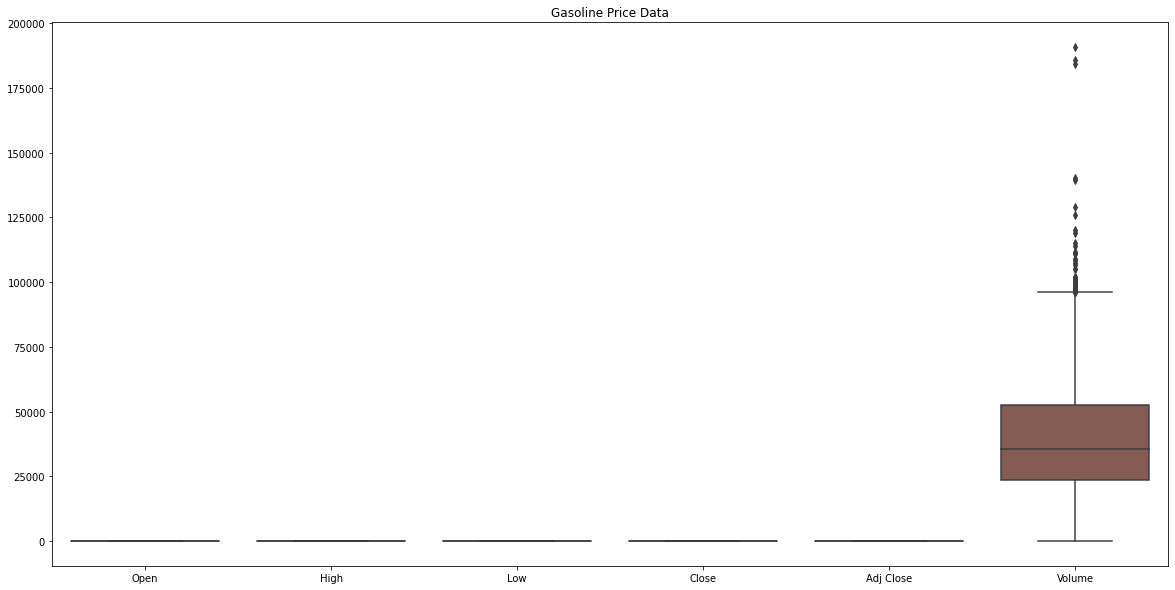

In [25]:
numerical_data = [col for col in gasoline.columns if gasoline[col].dtype == 'float64']
plt.figure(figsize=(20, 10))
sns.boxplot(data=gasoline[numerical_data]).set_title('Gasoline Price Data')
plt.show()

Kolom 'Volume' terdeteksi memiliki outliers. Oleh karena itu kita akan mengatasi data-data outliers ini menggunakan IQR Method dengan cara kerja menghapus data-data yang berada di luar IQR

In [26]:
Q1 = gasoline.quantile(.25)
Q3 = gasoline.quantile(.75)
IQR = Q3 - Q1
gasoline=gasoline[~((gasoline<(Q1-1.5*IQR))|(gasoline>(Q3+1.5*IQR))).any(axis=1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  after removing the cwd from sys.path.


Berikut adalah data kita setelah outliers dihilangkan

In [28]:
print(f'Data consist of {gasoline.shape[1]} columns')
print(f'Each column consists of {gasoline.shape[0]} records')

Data consist of 7 columns
Each column consists of 5195 records


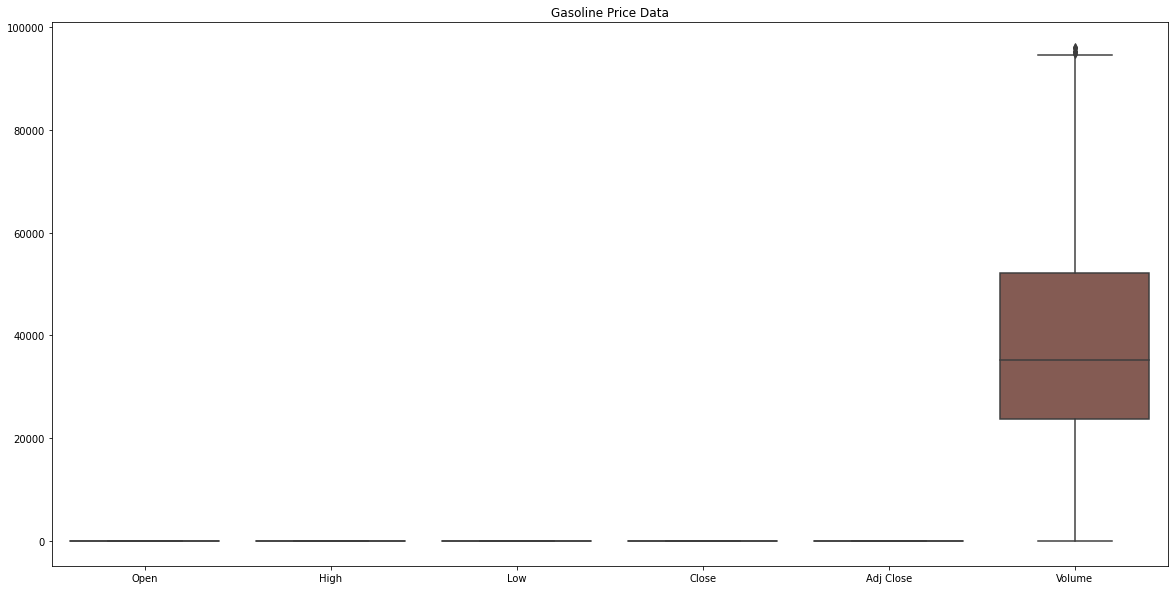

In [29]:
numerical_data = [col for col in gasoline.columns if gasoline[col].dtype == 'float64']
plt.figure(figsize=(20, 10))
sns.boxplot(data=gasoline[numerical_data]).set_title('Gasoline Price Data')
plt.show()

## **Univariate Analysis**

Kolom target kita adalah kolom 'Adj Close' sehingga kita hanya akan fokus ke sana

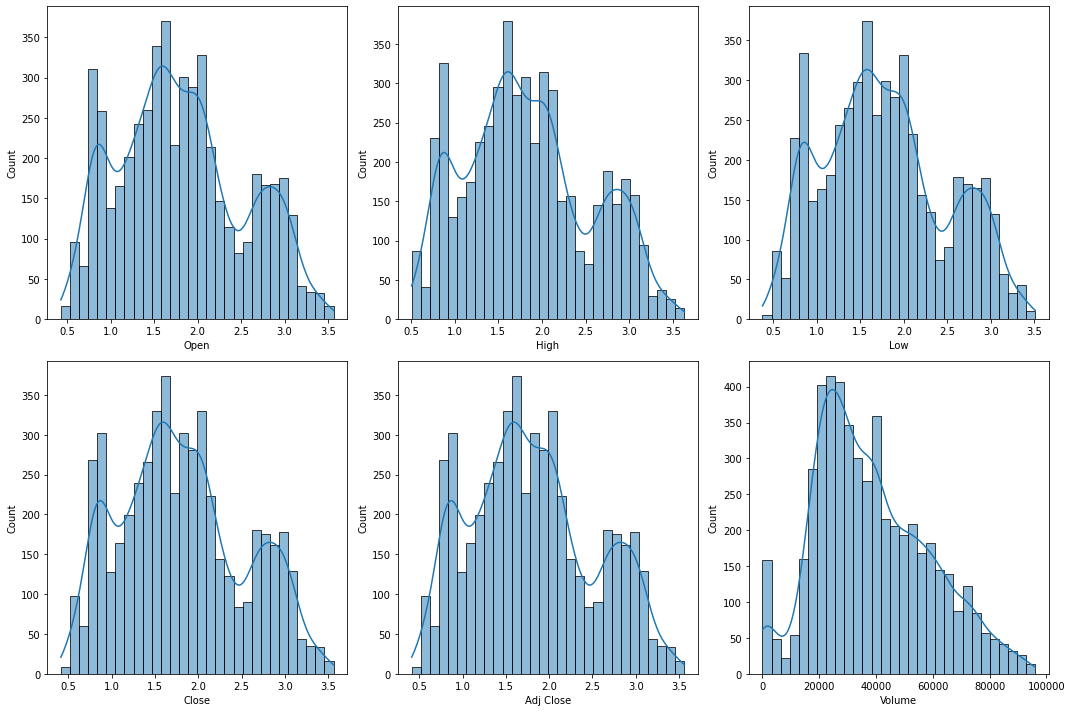

In [31]:
cols = 3
rows = 2
fig = plt.figure(figsize=(cols * 5, rows * 5))

for i, col in enumerate(numerical_data):
  ax = fig.add_subplot(rows, cols, i + 1)
  sns.histplot(x=gasoline[col], bins=30, kde=True, ax=ax)
fig.tight_layout()
plt.show()

## **Multivariate Analysis**

Pada tahap ini kita akan melihat korelasi dari kolom 'Adj Close' dengan kolom-kolom lainnya. Pada plot di bawah kita hanya perlu untuk fokus pada plot baris ke-5. Di sana terlihat jelas bahwa kolom 'Adj Close' memiliki korelasi positif kuat terhadap kolom 'Open', 'High', 'Low', 'Close'. Sementara hubungan dengan kolom 'Volume' adalah korelasi yang lemah

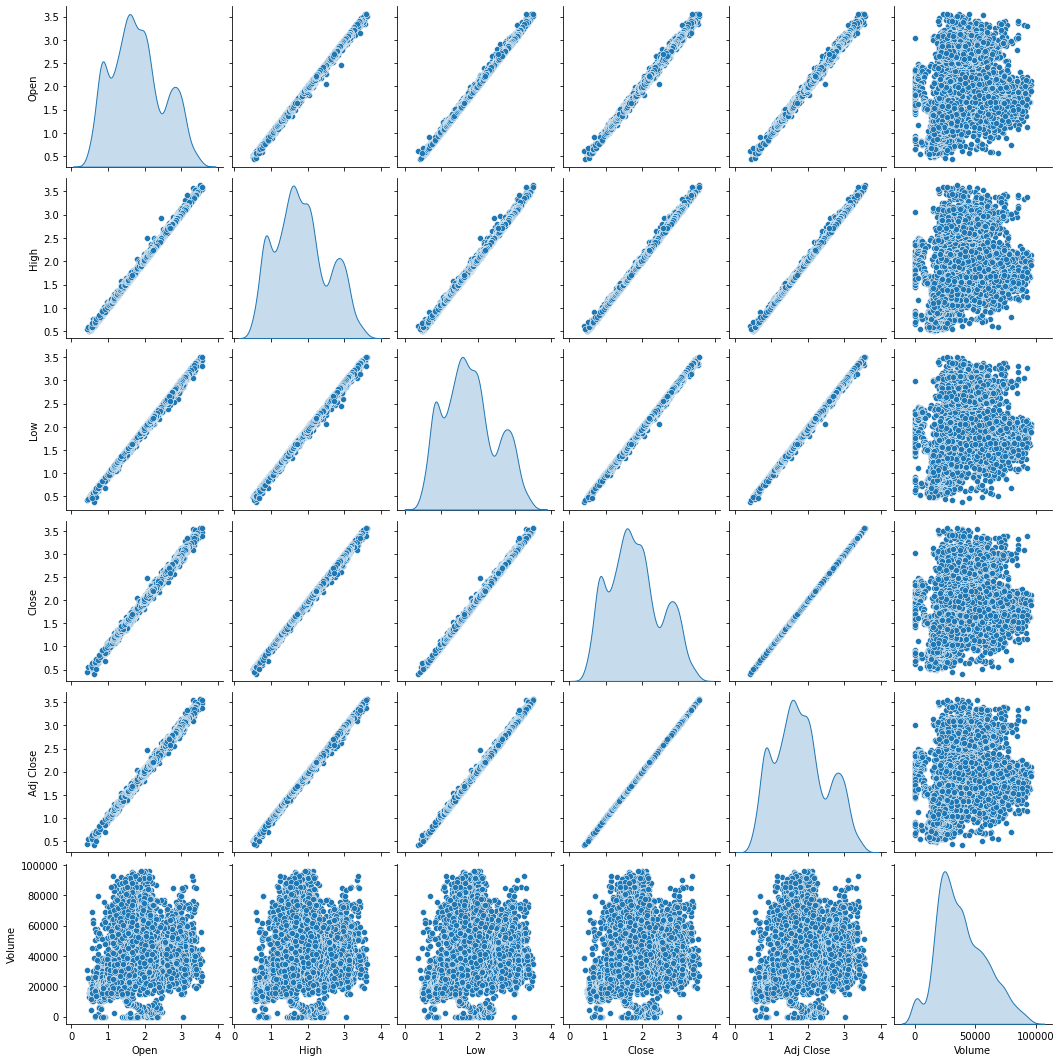

In [32]:
sns.pairplot(gasoline[numerical_data], diag_kind='kde')
plt.show()

Untuk melihat nilai korelasi dengan lebih jelas, kita bisa memanfaatkan Heatmap dari library Seaborn

Text(0.5, 1.0, 'Matrix Correlation')

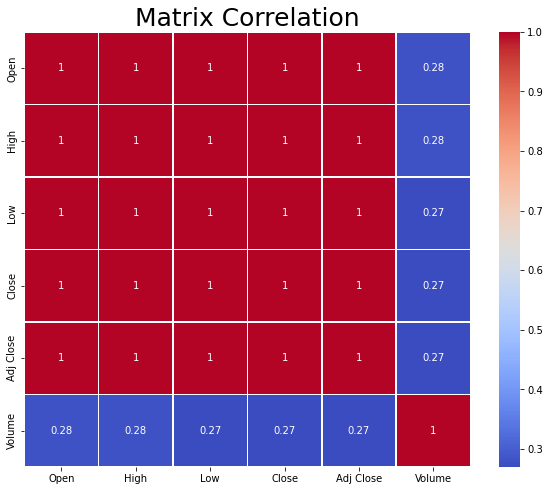

In [33]:
plt.figure(figsize=(10, 8))
correlation_matrix = gasoline.corr().round(2)

# untuk print nilai dalam kotak gunakan anot true
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrix Correlation', size=25)

# **Preparing Data**

## **Drop Unused Data**

Pada bagian ini kita akan menghapus beberapa kolom yang dapat mengganggu proses training model. Kolom-kolom tersebut adalah kolom 'Date', 'Close', dan 'Volume'

In [36]:
gasoline = gasoline.drop(['Date', 'Close', 'Volume'], axis=1)

In [37]:
gasoline.head()

,Open,High,Low,Adj Close
0,0.8890,0.8970,0.882,0.8840
1,0.8750,0.8876,0.863,0.8688
2,0.8675,0.8750,0.860,0.8695
3,0.8600,0.8850,0.856,0.8825
4,0.8930,0.9000,0.886,0.8910


## **Splitting Train and Test**

In [39]:
X = gasoline.iloc[:, :-1].values
y = gasoline.iloc[:, -1].values

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print('x_train = ', (len(x_train)), ' records')
print('y_train = ', (len(y_train)), ' records')
print('x_test = ', (len(x_test)), ' records')
print('y_test = ', (len(y_test)), ' records')

x_train =  4156  records
y_train =  4156  records
x_test =  1039  records
y_test =  1039  records


## **Normalization**

Kita akan menormalisasi data dengan mengubahnya berada dalam rentang 0 hingg 1. Normalisasi ini akan menggunakan bantuan MinMaxScaler

In [42]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

# **Model Development**

In [54]:
models = pd.DataFrame(columns=['train_mse', 'test_mse'], index=['SVR', 'KNN', 'GradientBoosting'])

## **Hyperparameter Tuning**

Hyperparameter tuning adalah penambah model otomatis yang disediakan oleh AI Platform Training guna mencapai model terbaik. Akan tetapi, kita juga dapat menguah hyperparameter tuning secara manual dengan menggunakan bantuan GridSearch. GridSearch merupakan sebuah teknik yang memungkinkan kita untuk menguji beberapa hyperparameter sekaligus pada sebuah model

In [44]:
def grid_search(model, hyperparameters):
  results = GridSearchCV(
      model,
      hyperparameters,
      cv=5,
      verbose=1,
      n_jobs=6
  )

  return results

In [46]:
svr = SVR()
hyperparameters = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 10, 100, 1000],
    'gamma': [0.3, 0.03, 0.003, 0.0003]
}

svr_search = grid_search(svr, hyperparameters)
svr_search.fit(x_train, y_train)
print(svr_search.best_params_)
print(svr_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 1000, 'gamma': 0.003, 'kernel': 'rbf'}
0.9987850417580644


In [47]:
gradient_boost = GradientBoostingRegressor()
hyperparameters = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'n_estimators': [250, 500, 750, 1000],
    'criterion': ['friedman_mse', 'squared_error']
}

gradient_boost_search = grid_search(gradient_boost, hyperparameters)
gradient_boost_search.fit(x_train, y_train)
print(gradient_boost_search.best_params_)
print(gradient_boost_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'criterion': 'squared_error', 'learning_rate': 0.01, 'n_estimators': 1000}
0.9991242374692113


In [48]:
knn = KNeighborsRegressor()
hyperparameters = {
    'n_neighbors': range(1, 10)
}

knn_search = grid_search(knn, hyperparameters)
knn_search.fit(x_train, y_train)
print(knn_search.best_params_)
print(knn_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'n_neighbors': 6}
0.9993239773167586


## **Fitting Model**

Setelah mendapatkan hyperparameter terbaik melalui proses hyperparameter tuning, maka sekarang adalah saatnya kita melatih model dengan hyperparameter terbaik. Di sini kita akan menggunakan tiga algoritma yaitu SVR, Gradient Boost, dan KNN

In [49]:
svr = SVR(C=1000, gamma=0.003, kernel='rbf')
svr.fit(x_train, y_train)

SVR(C=1000, gamma=0.003)

In [50]:
gradient_boost = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01, n_estimators=1000)
gradient_boost.fit(x_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01,
                          n_estimators=1000)

In [51]:
knn = KNeighborsRegressor(n_neighbors=6)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=6)

## **Model Evaluation**

Setelah menerapkan tiga algoritma pada model kita, kali ini kita akan menghitung nilai MSE terkecil dari seluruh algoritma

In [55]:
model_dict = {
    'SVR': svr,
    'GradientBoosting': gradient_boost,
    'KNN': knn,
}

for name, model in model_dict.items():
  models.loc[name, 'train_mse'] = mean_squared_error(y_train, model.predict(x_train))
  models.loc[name, 'test_mse'] = mean_squared_error(y_test, model.predict(x_test))

models.head()

,train_mse,test_mse
SVR,0.000561,0.000521
KNN,0.00023,0.000274
GradientBoosting,0.000263,0.000384


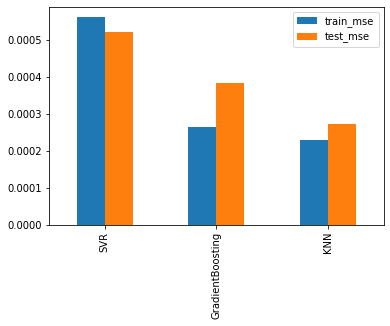

In [56]:
models.sort_values(by='test_mse', ascending=False).plot(kind='bar', zorder=3)

Dari plot dan data di atas, KNN adalah algoritma terbaik yang memberikan MSE terkecil, untuk lebih jelasnya kita akan mencari akurasi dari setiap algoritma.

In [58]:
svr_acc = svr.score(x_test, y_test)*100
boosting_acc = gradient_boost.score(x_test, y_test)*100
knn_acc = knn.score(x_test, y_test)*100

In [60]:
evaluation_list = [[svr_acc], [boosting_acc], [knn_acc]]
evaluation = pd.DataFrame(evaluation_list,
                          columns = ['Accuracy (%)'],
                          index = ['SVR', 'Gradient Boost', 'KNN'])

evaluation

,Accuracy (%)
SVR,99.895014
Gradient Boost,99.922762
KNN,99.944909


Hasil evaluasi di atas juga menunjukkan bahwa KNN adalah algoritma terbaik untuk model kita dengan skor 99.94%

# **Forecasting**

Setelah mendapatkan algoritma KNN sebagai algoritma terbaik, maka sekarang kita akan mencoba meramal (forecasting) harga bensin selama satu minggu ke depan dengan menggunakan algoritma KNN

In [61]:
X_7=X[-7:]
forecast=knn.predict(X_7)

In [62]:
forecast=pd.DataFrame(forecast,columns=['Forecast'])
gasoline1=gasoline.append(forecast)
gasoline1.drop(['High', 'Low', 'Open'],axis=1,inplace=True)

In [63]:
gasoline1.tail(14)

,Adj Close,Forecast
5239,2.1704,NaN
5240,2.1941,NaN
5241,2.2018,NaN
5242,2.2115,NaN
5243,2.1931,NaN
5244,2.2190,NaN
5245,2.2025,NaN
0,NaN,3.518567
1,NaN,3.518567
2,NaN,3.518567
